In [1]:
import numpy as np 
import pandas as pd 
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
import itertools
from datetime import datetime
%matplotlib inline 

# fig_size = plt.rcParams["figure.figsize"] 
# fig_size[0] = 12 
# fig_size[1] = 12 
plt.rcParams["figure.figsize"] = (12,12) 

from sklearn import model_selection 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import preprocessing # for scale
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from concurrent.futures import ThreadPoolExecutor, as_completed

import pickle
import importlib

import finalproj as fp
import corinne

In [2]:
# importlib.reload(fp)
# importlib.reload(corinne)

In [3]:
# features_train_pickled = np.array(pickle.load(open('features_train', 'rb')))
# labels_train_pickled = np.array(pickle.load(open('labels_train', 'rb')))
# features_train_pickled.shape, labels_train_pickled.shape

In [4]:
# pd.DataFrame(features_train_pickled).to_csv('features_train.csv', header=False, index=False)
# pd.DataFrame(labels_train_pickled).to_csv('labels_train.csv', header=False, index=False)

In [5]:
features_train = pd.read_csv('features_train.csv', header=None).values
labels_train = pd.read_csv('labels_train.csv', header=None).values.ravel()
features_train.shape, labels_train.shape

((8640, 2048), (8640,))

In [6]:
features_train[:1]

array([[ 0.1598925 ,  0.0603989 ,  0.2465315 , ...,  0.12065897,
         0.8170203 ,  0.33522028]])

In [7]:
labels_train[:2]

array(['001.Black_footed_Albatross', '001.Black_footed_Albatross'], dtype=object)

In [8]:
# X_scaled = preprocessing.scale(features_train)
# X_scaled.shape

_Pick two classes of your choice from the dataset. Train an L2-regularized logistic regression classiﬁer on the training set using your own fast gradient algorithm with λ = 1. Plot, with diﬀerent colors, the misclassiﬁcation error on the training set and on the validation set vs iterations._

I'll pick 086, Pacific Loon, and 087, Mallard, as the two classes.

Per Zaid's answer on 5/27, in this problem I'm considering just the subset of the data that has these two classes. I pull the data and train/test a binary classifer. I only use the 60 observations for the two chosen birds.

In [21]:
indices_twoclasses = np.where((labels_train == '086.Pacific_Loon') | (labels_train == '087.Mallard'))
indices_twoclasses

(array([3360, 3361, 3362, 3363, 3364, 3365, 3366, 3367, 3368, 3369, 3370,
        3371, 3372, 3373, 3374, 3375, 3376, 3377, 3378, 3379, 3380, 3381,
        3382, 3383, 3384, 3385, 3386, 3387, 3388, 3389, 3390, 3391, 3392,
        3393, 3394, 3395, 3396, 3397, 3398, 3399, 3400, 3401, 3402, 3403,
        3404, 3405, 3406, 3407, 3408, 3409, 3410, 3411, 3412, 3413, 3414,
        3415, 3416, 3417, 3418, 3419, 3420, 3421, 3422, 3423, 3424, 3425,
        3426, 3427, 3428, 3429, 3430, 3431, 3432, 3433, 3434, 3435, 3436,
        3437, 3438, 3439, 3440, 3441, 3442, 3443, 3444, 3445, 3446, 3447,
        3448, 3449, 3450, 3451, 3452, 3453, 3454, 3455, 3456, 3457, 3458,
        3459, 3460, 3461, 3462, 3463, 3464, 3465, 3466, 3467, 3468, 3469,
        3470, 3471, 3472, 3473, 3474, 3475, 3476, 3477, 3478, 3479]),)

In [22]:
X_twoclasses_notscaled = features_train[indices_twoclasses]
X_twoclasses_notscaled.shape

(120, 2048)

In [23]:
y_twoclasses = np.where(labels_train[indices_twoclasses] == '086.Pacific_Loon', 1, -1)
y_twoclasses.shape

(120,)

In [24]:
def get_probability(logodds):
    return 1 / (1 + np.exp(-logodds))
    #return np.exp(logodds) / (1 + np.exp(logodds))

def get_accuracy(beta_coefs, X, y_actual, prob_threshold=0.5):
    """
    Return the classification accuracy given a set of coefficients, in 
    beta_coefs, and observations, in X, compared to actual/known values 
    in y_actual. The threshold parameter defines the value above which the
    predicted value is considered a positive example.
    """
    y_pred = X.dot(beta_coefs.T).ravel() # ravel to convert to vector
    
    # for logistic regression convert to a prob and use a prob threshold
    probs = get_probability(y_pred)
    y_thresholded = np.where(probs > prob_threshold, 1, -1)
    
    return accuracy_score(y_actual, y_thresholded)

In [25]:
X_twoclasses_train_notscaled, X_twoclasses_test_notscaled, y_twoclasses_train, y_twoclasses_test = model_selection.train_test_split(
    X_twoclasses_notscaled, y_twoclasses, test_size=0.3)
X_twoclasses_train_notscaled.shape, X_twoclasses_test_notscaled.shape, y_twoclasses_train.shape, y_twoclasses_test.shape

((84, 2048), (36, 2048), (84,), (36,))

In [26]:
scaler = preprocessing.StandardScaler().fit(X_twoclasses_train_notscaled)
X_twoclasses_train = scaler.transform(X_twoclasses_train_notscaled)
X_twoclasses_test = scaler.transform(X_twoclasses_test_notscaled)

In [27]:
t_init = 0.01
max_iters = 100

In [28]:
results = fp.fastgradalgo(
    X_twoclasses_train, y_twoclasses_train, t_init=t_init, 
    grad_func = fp.compute_gradient_logistic_regression, 
    obj_func = fp.compute_objective_logistic_regression, 
    lam=1, max_iter=max_iters)
results[-3:]

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
98,-0.009093,0.003823,0.007711,-0.003041,-0.002734,-0.003316,0.001048,0.001144,-0.000396,0.001147,...,-0.002955,-0.000058,0.005172,-0.009743,0.004864,0.005105,-0.007126,-0.009896,-0.007183,0.003237
99,-0.009093,0.003823,0.007711,-0.003041,-0.002734,-0.003316,0.001048,0.001143,-0.000397,0.001147,...,-0.002954,-0.000058,0.005173,-0.009743,0.004863,0.005105,-0.007125,-0.009896,-0.007183,0.003237
100,-0.009092,0.003823,0.007711,-0.003042,-0.002734,-0.003316,0.001048,0.001143,-0.000397,0.001147,...,-0.002954,-0.000058,0.005173,-0.009743,0.004862,0.005104,-0.007125,-0.009896,-0.007182,0.003237


In [29]:
# note use of the held out test data to get the performance metrics
accuracy = get_accuracy(fp.get_final_coefs(results), X_twoclasses_test, y_twoclasses_test)
print("Accuracy: {0:.1%}".format(accuracy))
print("Misclassification error: {0:.1%}".format(1 - accuracy))

Accuracy: 100.0%
Misclassification error: 0.0%


In [30]:
def get_objective_values(beta_results_df, X, y, lam):
    return beta_results_df.apply(lambda r: fp.compute_objective_logistic_regression(r.values, 
                                                    X, y, lam), axis=1)

In [31]:
obj_vals = pd.DataFrame({'Train': get_objective_values(results, X_twoclasses_train, y_twoclasses_train, 1),
              'Validation': get_objective_values(results, X_twoclasses_test, y_twoclasses_test, 1)})
obj_vals[:3]

,Train,Validation
0,0.693147,0.693147
1,0.207155,0.214928
2,0.163775,0.180278


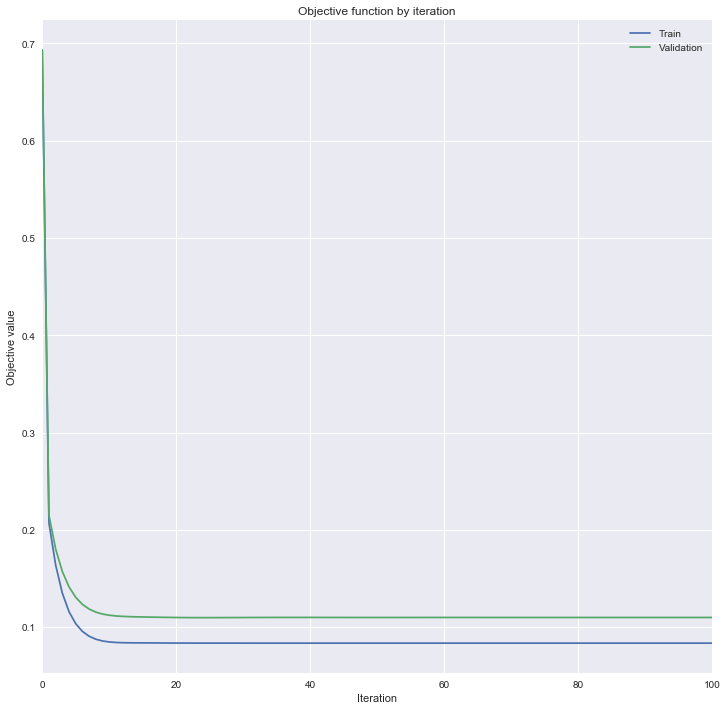

In [32]:
ax = obj_vals.plot()
ax.set_xlabel('Iteration')
ax.set_ylabel('Objective value')
ax.set_title('Objective function by iteration')

In [33]:
def get_misclassification_errors(beta_results_df, X, y):
    return beta_results_df.apply(lambda r: 1 - get_accuracy(r.values, X, y), axis=1)

In [34]:
errors = pd.DataFrame({'Train': get_misclassification_errors(results, X_twoclasses_train, y_twoclasses_train),
              'Validation': get_misclassification_errors(results, X_twoclasses_test, y_twoclasses_test)})
errors[:3]

,Train,Validation
0,0.488095,0.527778
1,0.047619,0.055556
2,0.011905,0.055556


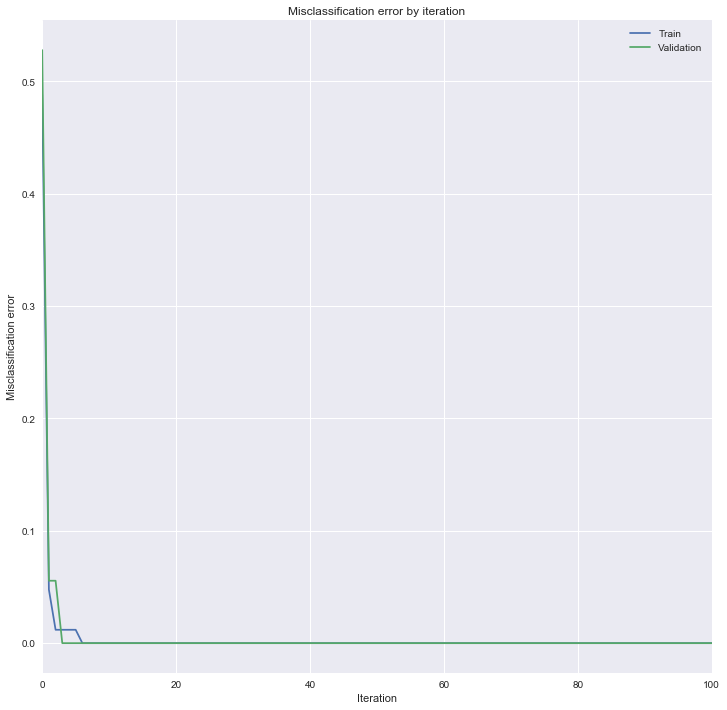

In [35]:
ax = errors.plot()
ax.set_xlabel('Iteration')
ax.set_ylabel('Misclassification error')
ax.set_title('Misclassification error by iteration')

What if we use LinearSVC - what do we get then?

In [36]:
model_twoclasses = LinearSVC().fit(X_twoclasses_train, y_twoclasses_train)

In [37]:
accuracy_score(y_twoclasses_test, model_twoclasses.predict(X_twoclasses_test))

1.0

In [38]:
model_twoclasses.predict(X_twoclasses_test)

array([-1, -1,  1, -1, -1, -1,  1,  1,  1,  1, -1,  1,  1, -1, -1, -1, -1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1, -1, -1, -1,  1,  1,
       -1, -1])

In [39]:
model_twoclasses.decision_function(X_twoclasses_test)

array([-1.06834394, -0.89524006,  1.24180952, -1.11047946, -0.23563293,
       -1.24182146,  1.08023579,  0.78849224,  1.38968271,  1.44913856,
       -1.15275861,  1.34963177,  0.89528922, -0.98041875, -1.12260562,
       -0.26078089, -0.94624889,  1.65260086,  1.34220727,  1.01992125,
        1.54982279,  1.13346982,  1.14059943,  1.62840895,  1.66905827,
       -0.52045929,  1.07211772,  1.40396675, -1.18491411, -0.75844934,
       -1.06976445, -0.99905193,  0.8552065 ,  0.79095277, -0.95212425,
       -1.21110218])

What about sklearn's logistic regression?

In [40]:
model_twoclasses_lr = LogisticRegression().fit(X_twoclasses_train, y_twoclasses_train)

In [41]:
accuracy_score(y_twoclasses_test, model_twoclasses_lr.predict(X_twoclasses_test))

1.0

In [42]:
model_twoclasses_lr.predict(X_twoclasses_test)

array([-1, -1,  1, -1, -1, -1,  1,  1,  1,  1, -1,  1,  1, -1, -1, -1, -1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1, -1, -1, -1,  1,  1,
       -1, -1])

In [43]:
model_twoclasses_lr.decision_function(X_twoclasses_test)

array([ -8.4763828 ,  -6.36950841,   8.66145017,  -8.5259731 ,
        -1.82804037,  -9.06268159,   7.9171625 ,   6.07836858,
        10.03361733,  11.12697073,  -8.68948509,  10.06613011,
         6.70695223,  -5.67236886,  -8.97140454,  -2.00154652,
        -7.55950142,  12.27162795,  10.21503891,   8.20236246,
        11.54165205,   8.52498998,   7.78774868,  11.90821373,
        11.77618246,  -3.6832443 ,   7.97332404,  10.45108923,
        -9.20951982,  -4.81802113,  -8.23895226,  -6.8533608 ,
         6.74111148,   4.68701149,  -5.80869434,  -9.02302999])

And now let's use the new class-based wrapper for my implementation.

In [44]:
importlib.reload(fp)

<module 'finalproj' from '/Users/andrewenfield/work/github/Data558/Kaggle/finalproj.py'>

In [51]:
mylr = fp.MyLogisticRegression(max_iter=100)

In [52]:
mylr.fit(X_twoclasses_train, y_twoclasses_train)

MyLogisticRegression(C=1, max_iter=100)

In [53]:
mylr.all_coefs_[-1:]

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
100,-0.009092,0.003823,0.007711,-0.003042,-0.002734,-0.003316,0.001048,0.001143,-0.000397,0.001147,...,-0.002954,-0.000058,0.005173,-0.009743,0.004862,0.005104,-0.007125,-0.009896,-0.007182,0.003237


In [47]:
mylr.get_coefs().shape

(1, 2048)

In [48]:
accuracy_score(y_twoclasses_test, mylr.predict(X_twoclasses_test))

1.0

In [83]:
mylr.predict(X_twoclasses_test)

array([-1,  1, -1,  1,  1, -1, -1,  1, -1, -1, -1, -1, -1, -1,  1,  1, -1,
        1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1,
        1,  1])

In [84]:
mylr.decision_function(X_twoclasses_test)

array([-3.06481535,  4.39295563, -1.89668996,  4.76754851,  3.99933668,
       -3.04772065, -3.8291444 ,  4.32226931, -3.00702435, -4.73742516,
       -3.76140665, -0.32864841, -0.34086524, -1.50060743,  3.38328952,
        2.8549922 , -4.33881882,  5.53318727,  4.93739004,  5.24137488,
       -1.37329157,  5.30691387,  4.96130481, -1.30303672,  4.45931476,
        2.73641432,  5.31184968,  3.23331002,  3.24110197, -1.21393641,
        5.33075452,  2.47441586,  4.94322534, -4.2698721 ,  4.99450264,
        3.38608213])

## Corinne verification - using her code, do we see the same results?

In [19]:
results_corinne, thetas_corinne = corinne.fastgradalgo(np.zeros(X_train.shape[1]),
                                       np.zeros(X_train.shape[1]),
                                       1,
                                       0.01,
                                       100,
                                       X_train,
                                       y_train)
results_corinne.shape

NameError: name 'X_train' is not defined

In [20]:
results_corinne

NameError: name 'results_corinne' is not defined

In [21]:
corinne.objective_plot(results_corinne, 1, X_train, y_train)

NameError: name 'results_corinne' is not defined

In [22]:
corinne.compute_misclassification_error(results_corinne[100,:], X_test, y_test)

NameError: name 'results_corinne' is not defined

In [23]:
corinne.compute_misclassification_error(results.values[100,:], X_test, y_test)

NameError: name 'X_test' is not defined

In [24]:
results_corinne[2,:]

NameError: name 'results_corinne' is not defined

In [25]:
results.values[2, :]

array([-0.00333503,  0.00057126,  0.00208173, ..., -0.00391905,
       -0.00173726,  0.00095118])

In [26]:
lambduh = 1
d = X_train.shape[1]
beta_init = np.zeros(d)
theta_init = np.zeros(d)
eta_init = 1/(scipy.linalg.eigh(1/len(y_train)*X_train.T.dot(X_train), 
                                eigvals=(d-1, d-1), eigvals_only=True)[0]+lambduh)
maxiter = 300
#betas_grad = corinne.graddescent(beta_init, lambduh, eta_init, maxiter, X_train, y_train)
betas_fastgrad, thetas_fastgrad = corinne.fastgradalgo(beta_init, theta_init, lambduh, eta_init, maxiter,
                                                       X_train, y_train)
betas_fastgrad.shape
#objective_plot(betas_grad, betas_fastgrad, lambduh, save_file='hw3_q1_part_h_output.png')


NameError: name 'X_train' is not defined

In [27]:
betas_fastgrad[-1:]

NameError: name 'betas_fastgrad' is not defined

In [28]:
corinne.compute_misclassification_error(betas_fastgrad[-1,:], X_test, y_test)

NameError: name 'betas_fastgrad' is not defined

Ok, so, bottom line, we get the same results from our code as we do from Corinne's code, even when we use the exact same setup/init code (for ex, that sets eta_init using X.T.dot(X)), and when we use Corinne's code that does backtracking compared to our code, above, where we're not using backtracking. I think this is good enough for me to accept that w/ a lambda of 1 at least, logistic regression is way worse than just returning negative all the time.

What do we see when we use our backtracking impl?

In [29]:
results = fp.fastgradalgo(
    X_train, y_train, t_init=t_init, 
    grad_func = fp.compute_gradient_logistic_regression, 
    obj_func = fp.compute_objective_logistic_regression, 
    lam=1, max_iter=100)
results[-3:]

NameError: name 'X_train' is not defined

In [30]:
results = fp.fastgradalgo(
    X_train, y_train, t_init=t_init, 
    grad_func = fp.compute_gradient_logistic_regression, 
    obj_func = fp.compute_objective_logistic_regression, 
    lam=1, max_iter=300, t_func=fp.backtracking)
results[-3:]

NameError: name 'X_train' is not defined

In [31]:
corinne.compute_misclassification_error(results.values[-1,:], X_test, y_test)

NameError: name 'X_test' is not defined

In [32]:
1 - get_accuracy(results.values[-1,:], X_test, y_test)

NameError: name 'X_test' is not defined

Ok, so we get the same results w/ our own backtracking implementation. Note again that since our stopping criteria is _only_ the number of iterations, we don't automatically get any benefit from the improved step sizes that backtracking gives us. That said, we still in theory could get to the minimum faster, which means if we're manually setting max_iter based on experimentation, then backtracking could help.

Finally, it's possible that backtracking adds enough processing time that we might want to run w/ it off if we're not going to use it. 

Although, backtracking might not _just_ give us better steps sizes leading to quicker convergence. It seems like it could also help us avoid the case where we _don't_ converge, if it keeps us from using a static/single step size that at some point means we're moving back and forth on our objective value without decreasing.

Bottom line, if i care, I should probably benchmark, and watch for non-convergence being fixed when we use backtracking. I'll keep that in mind.

Also, separately, it seems like my impl is way faster than Corinne's - I can run w/ 300 iterations in just a few secs while it takes her's well more than 10-20s it seems, anecdotally. It might be interesting to profile and see if a) this is really the case, and b) if so, why.

In [33]:
corinne.objective_plot(results.values, 1, X_train, y_train)

NameError: name 'X_train' is not defined

In [34]:
[fp.compute_objective_logistic_regression(coefs, X_train, y_train, 1) for coefs in results.values][:10]

NameError: name 'X_train' is not defined

_Find the value of the regularization parameter λ using cross-validation; you may use scikit-learn’s built-in functions for this purpose. Train an L2-regularized logistic regression classiﬁer on the training set using your own fast gradient algorithm with that value of λ found by cross-validation. Plot, with diﬀerent colors, the misclassiﬁcation error on the training set and on the validation set vs iterations._

In [35]:
importlib.reload(fp)
importlib.reload(corinne)

<module 'corinne' from '/Users/andrewenfield/work/github/Data558/Kaggle/corinne.py'>

In [48]:
lambdas = [10 ** exponent for exponent in range(-5,2)]
lambdas

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]

In [49]:
lams, scores = fp.cross_validate(10, X_twoclasses_train, y_twoclasses_train, lambdas, max_iters=100)

In [50]:
list(zip(lams, scores))

[(1e-05, 1.0),
 (0.0001, 1.0),
 (0.001, 1.0),
 (0.01, 1.0),
 (0.1, 1.0),
 (1, 1.0),
 (10, 1.0)]

In [51]:
results_best = fp.fastgradalgo(
    X_twoclasses_train, y_twoclasses_train, t_init=t_init, 
    grad_func = fp.compute_gradient_logistic_regression, 
    obj_func = fp.compute_objective_logistic_regression, 
    lam=0, max_iter=max_iters)
results_best[-3:]

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
98,-0.016897,0.000013,0.014302,-0.012089,-0.006965,0.002027,-0.004603,0.005204,-0.003159,-0.010236,...,-0.002022,-0.003080,0.006612,-0.023467,0.014312,0.011063,-0.015411,-0.023624,-0.021349,0.002132
99,-0.016943,0.000015,0.014340,-0.012124,-0.006985,0.002033,-0.004630,0.005210,-0.003176,-0.010276,...,-0.002028,-0.003088,0.006627,-0.023539,0.014343,0.011102,-0.015448,-0.023690,-0.021407,0.002136
100,-0.016989,0.000017,0.014377,-0.012159,-0.007004,0.002039,-0.004656,0.005216,-0.003193,-0.010315,...,-0.002033,-0.003096,0.006643,-0.023610,0.014373,0.011140,-0.015485,-0.023755,-0.021463,0.002140


In [52]:
fp.get_accuracy(fp.get_final_coefs(results_best), X_twoclasses_test, y_twoclasses_test)

1.0

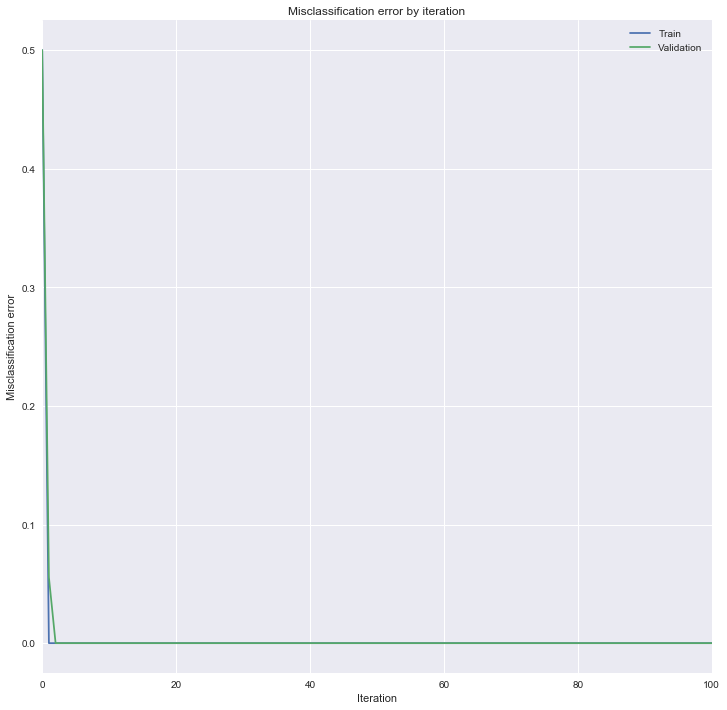

In [53]:
fp.plot_misclassification_errors_by_iteration(results_best, X_twoclasses_train, X_twoclasses_test, 
                                              y_twoclasses_train, y_twoclasses_test)

# Homework five

In [54]:
importlib.reload(fp)
importlib.reload(corinne)

<module 'corinne' from '/Users/andrewenfield/work/github/Data558/Kaggle/corinne.py'>

_Pick k = 5 classes of your choice from the dataset. You may choose any subset of 5 classes among all classes of the dataset._

In [55]:
classifier_labels = ['086.Pacific_Loon','044.Frigatebird','095.Baltimore_Oriole',
                     '154.Red_eyed_Vireo','188.Pileated_Woodpecker']

_Write a function that, for any class at hand, creates a training set with an equal number of examples from the class at hand and from the other classes. You may simply randomly pick the examples from the other classes._

In [56]:
X_incl086_train, X_incl086_test, labels_incl086_train, labels_incl086_test = fp.get_train_tst_balanced_set('086.Pacific_Loon', X_scaled, labels_train)
y_incl086_train = np.where(labels_incl086_train == '086.Pacific_Loon', 1, -1)
X_incl086_train.shape, y_incl086_train.shape

((42, 2048), (42,))

_For each class c, train an L2-regularized logistic regression classiﬁer using your own fast gradient algorithm with λc = 1. Display the confusion matrix. Which classes seem to be the most diﬃcult to classify?_

In [57]:
error_rate, cm, actual_labels, predicted_labels = fp.get_results_for_lambdas(classifier_labels, X_scaled, 
                                                        labels_train, np.ones(5), random_state=100)
error_rate

0.088888888888888906

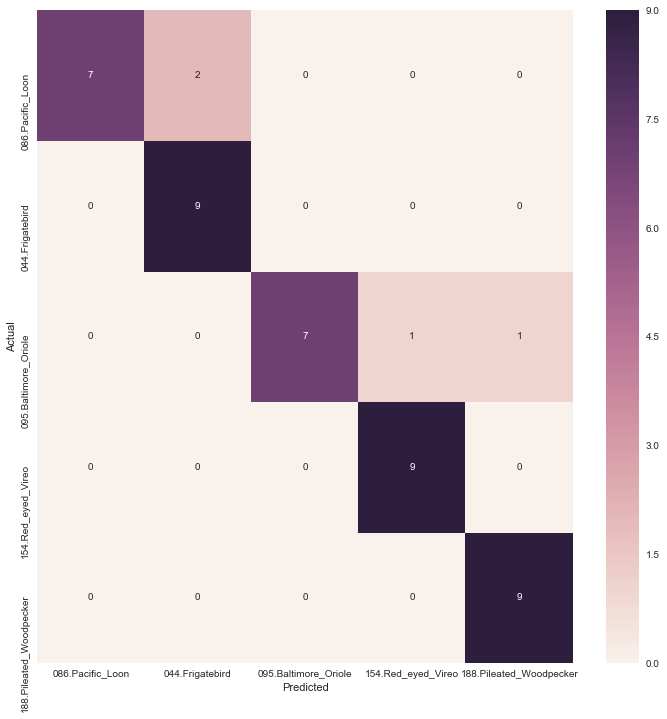

In [58]:
fp.plot_multiclass_confusion_matrix(cm, classifier_labels)

If we look at individual confusion matrices for each classifier, why do we always get a 0 in one corner? This means that we never have any false negatives - that is, we never predict -1 when it's actually 1. We do the other three. Why?

So, this means that we never predict that it ISN'T the bird in question, when it is actually the bird in question. I tried w/ an array of thresholds from very low to very high, and while they changed some true negatives to false positives, they never changed any prediction to a false negative. Perhaps this is something that's not uncommon when you have a single 1-vs-rest classifier? For example, that classifier tends to see anything at all that looks remotely like the bird in question as the bird in question (leading to true positives when it IS the bird, and false positives when it's not), but does not - generally, or at all? - think that the bird in question is actually NOT the bird in question. I could also write the above or add in terms of precision and recall if I thought about it for a few more minutes.

_Write a function that returns the ranked list of classes in terms of classiﬁcation diﬃculty using the confusion matrix. Compute the multi-class misclassiﬁcation error._

In [59]:
test_results_df = pd.DataFrame({'Actual': actual_labels,
                                'Predicted': predicted_labels})
test_results_df[:2]

,Actual,Predicted
0,086.Pacific_Loon,086.Pacific_Loon
1,086.Pacific_Loon,086.Pacific_Loon


In [60]:
accuracy_by_class = test_results_df.groupby(['Actual']).agg(lambda g: 1 - accuracy_score(g['Actual'], g['Predicted']))
accuracy_by_class.rename(columns={'Predicted': 'Misclassification error'}, inplace=True)
accuracy_by_class.sort_values(['Misclassification error'], ascending=False, inplace=True)

accuracy_by_class

,Misclassification error
Actual,
044.Frigatebird,0.222222
095.Baltimore_Oriole,0.222222
086.Pacific_Loon,0.000000
154.Red_eyed_Vireo,0.000000
188.Pileated_Woodpecker,0.000000


In [61]:
print("Overall multi-class misclassification error: {:.1%}".format(1 - accuracy_score(actual_labels, predicted_labels)))

Overall multi-class misclassification error: 8.9%


_Find the values of the regularization parameters λ1,...,λk for the classiﬁers using a hold-out validation set strategy. Deﬁne a grid of values Λ for each parameter λc with c = 1,...,k. For each setting of the regularization parameters λ1,...,λk, where each λc can take values in Λ (independently), train all your k = 5 classiﬁers and save the multi-class misclassiﬁcation error on the validation set for each setting of the regularization parameters λ1,...,λk._

Note that I'm only running this with three possible values of lambda. Originally I ran it with five values (leading to 3125 possibilities) and, while it ran, it took a _long_ time, even after I parallelized it (multiple hours, if I recall correctly). For the purpose of the final project, I'm doing this section to show that I've done it, not to truly pick the best collection of lambdas. Accordingly, I'm going to optimize a bit for faster compute and only run this with three values of lambda and 27 possibilities. If I did need to use this code to find the best set of values, I'd take the computation hit and run it over a larger range of values.

In [62]:
lambdas = [10 ** exponent for exponent in range(-2,1)]
lambdas

[0.001, 0.01, 0.1, 1]

In [63]:
lambda_combinations = list(itertools.product(lambdas, repeat=5))
len(lambda_combinations)

1024

In [64]:
lambda_combinations[:3]

[(0.001, 0.001, 0.001, 0.001, 0.001),
 (0.001, 0.001, 0.001, 0.001, 0.01),
 (0.001, 0.001, 0.001, 0.001, 0.1)]

In [65]:
[fp.get_results_for_lambdas(classifier_labels, X_scaled, labels_train, lams)[0] for lams in lambda_combinations[:3]]

[0.19999999999999996, 0.28888888888888886, 0.17777777777777781]

In [ ]:
# print("Started at {}.".format(datetime.now()))

# misclassification_errors = []

# try:
#     for index, lams in enumerate(lambda_combinations[:10]):
#         if (index % 10 == 0):
#             print('Processing lambdas with index {}...'.format(index))

#         error = fp.get_results_for_lambdas(classifier_labels, X_scaled, labels_train, lams)[0]
#         misclassification_errors.append(error)

# except:
#     raise()
# finally:
#     print("Finished at {}. Processed {} sets of lambdas".format(datetime.now(), index+1))

In [ ]:
# misclassification_errors.sort()
# misclassification_errors

In [67]:
def get_misclassification_error_for_lambdas(lambdas):
    return lambdas, fp.get_results_for_lambdas(classifier_labels, X_scaled, labels_train, lambdas)[0]

# uses already-set (global - boo!) sets_per_labels, since this doesn't change at all for all the runs
# and to avoid having to update to take a tuple/deal with multiple arg unpacking (for now at least)
def get_misclassification_error_for_lambdas_with_shared_sets(lambdas):
    return lambdas, fp.get_results_for_lambdas(classifier_labels, X_scaled, labels_train, lambdas,
                                               sets_for_labels=sets_per_labels)[0]

def create_and_run_jobs(lambda_combinations, worker_job):
    with ThreadPoolExecutor(max_workers=10) as executor:
         return executor.map(worker_job, lambda_combinations)

In [70]:
# print("Started at {}.".format(datetime.now()))

# all_results = []

# results = create_and_run_jobs(lambda_combinations[:3], get_misclassification_error_for_lambdas)
# for result in results:
#     all_results.append(result)
    
# print("Finished at {}. Processed {} sets of lambdas.".format(datetime.now(), len(all_results)))

In [71]:
# all_results

In [72]:
# foo = [error for _, error in all_results]
# foo.sort()
# foo

And now, with the ability to generate the train-test sets just once, so that a) most importantly, each fastgradalgo run gets to use the same particular set of train/test data, so one doesn't have an easier or harder time than another, and b) it might be at least a bit faster since we only have to generate the train-test data once rather than for each of the runs for a set of five lambdas.

In [73]:
# the worker func requires the train-test sets to pointed to by the sets_per_labels variable - argh, global state (see above)
sets_per_labels = [fp.get_train_tst_balanced_set(classifier_label, X_scaled, labels_train) for classifier_label in classifier_labels]
len(sets_per_labels)

5

The code below is time-consuming, since it's building a set of one-vs-rest classifiers for each of the five classes, and it's doing this for 1024 combinations of four different lambda values. Even though I parallelized it, it still takes 60m minutes.

In [74]:
print("Started at {}.".format(datetime.now()))

all_results_shared_sets = []

results = create_and_run_jobs(lambda_combinations, get_misclassification_error_for_lambdas_with_shared_sets)
for result in results:
    all_results_shared_sets.append(result)
    
print("Finished at {}. Processed {} sets of lambdas.".format(datetime.now(), len(all_results_shared_sets)))

Started at 2017-05-31 09:50:31.771466.
Finished at 2017-05-31 10:45:53.307758. Processed 1024 sets of lambdas.


In [75]:
all_results_shared_sets[:3]

[((0.001, 0.001, 0.001, 0.001, 0.001), 0.17777777777777781),
 ((0.001, 0.001, 0.001, 0.001, 0.01), 0.24444444444444446),
 ((0.001, 0.001, 0.001, 0.001, 0.1), 0.28888888888888886)]

In [76]:
#pickle.dump(all_results_shared_sets, open('all_results_shared_sets', 'wb'))

In [80]:
# foo, bar, baz = zip(*all_results_shared_sets)

In [81]:
# baz

In [30]:
importlib.reload(fp)
importlib.reload(corinne)

<module 'corinne' from '/Users/andrewenfield/work/github/Data558/Kaggle/corinne.py'>

_Find the optimal value of the regularization parameters λ1,...,λk based on the validation error. Display the confusion matrix for this setting of the regularization parameters._

In [84]:
sorted(all_results_shared_sets, key=lambda t: t[1])[:20]

[((0.001, 0.01, 0.01, 1, 0.01), 0.088888888888888906),
 ((0.001, 0.1, 0.1, 0.01, 0.01), 0.088888888888888906),
 ((0.001, 0.1, 0.1, 0.1, 0.01), 0.088888888888888906),
 ((0.001, 0.1, 0.1, 1, 0.01), 0.088888888888888906),
 ((0.01, 1, 1, 0.1, 0.1), 0.088888888888888906),
 ((0.01, 1, 1, 1, 0.1), 0.088888888888888906),
 ((0.1, 1, 1, 0.1, 0.1), 0.088888888888888906),
 ((0.1, 1, 1, 1, 0.1), 0.088888888888888906),
 ((1, 1, 1, 0.1, 1), 0.088888888888888906),
 ((1, 1, 1, 1, 1), 0.088888888888888906),
 ((0.001, 0.001, 0.01, 1, 0.001), 0.11111111111111116),
 ((0.001, 0.01, 0.01, 0.001, 0.01), 0.11111111111111116),
 ((0.001, 0.01, 0.01, 0.01, 0.01), 0.11111111111111116),
 ((0.001, 0.01, 0.01, 0.1, 0.01), 0.11111111111111116),
 ((0.001, 0.01, 0.01, 1, 0.001), 0.11111111111111116),
 ((0.001, 0.01, 0.1, 0.01, 0.01), 0.11111111111111116),
 ((0.001, 0.01, 0.1, 0.1, 0.01), 0.11111111111111116),
 ((0.001, 0.01, 0.1, 1, 0.01), 0.11111111111111116),
 ((0.001, 0.01, 1, 0.1, 0.01), 0.11111111111111116),
 ((0.0

In [86]:
# Depending on the run sometimes there's more than one, so I'll look at the above
# output and set the best lambda manually instead of automatically w/ the code
# below; in addition in both runs I've done I've always had 1,1,1,1,1 be part of it
# so I'll go with that

# So, here's the best lambda values:
#lambdas_best = sorted(all_results_shared_sets, key=lambda t: t[1])[0][0]
lambdas_best = (1,1,1,1,1)
lambdas_best

(1, 1, 1, 1, 1)

In [88]:
# and we'll get the coefs/get the classifier (we didn't save the coef values from the run, so 
# will get them now)
results = [fp.get_classifier_for_label(classifier_label, X_scaled, labels_train, lam, sets_for_this_label) for
                                 classifier_label, lam, sets_for_this_label in zip(classifier_labels, lambdas_best, sets_per_labels)]
#final_coefs, X_test, labels_test = results
len(results)

5

In [89]:
misclassification_error, cm, _, _ = fp.get_results_for_lambdas(classifier_labels, X_scaled, labels_train, 
                                                               lambdas_best, sets_for_labels=sets_per_labels)
misclassification_error

0.088888888888888906

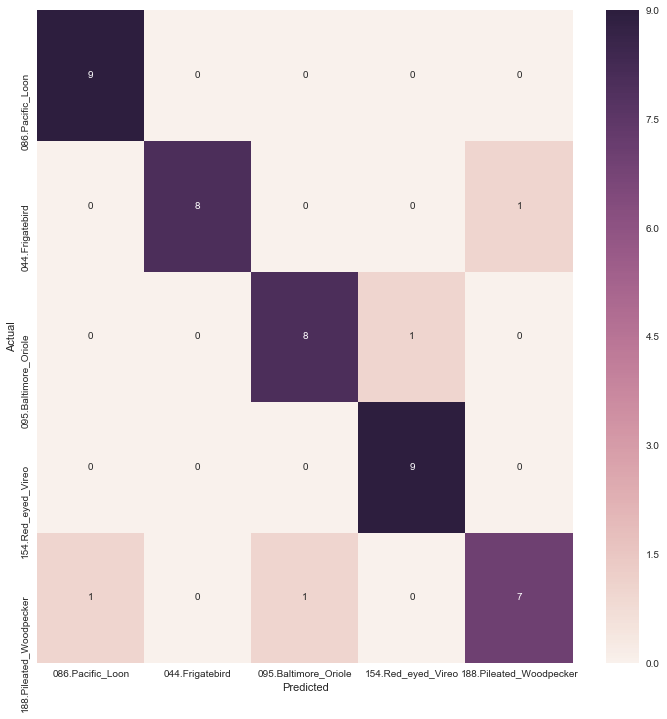

In [90]:
fp.plot_multiclass_confusion_matrix(cm, classifier_labels)

# Homework Seven

_In this exercise, you are going to train support vector machines (SVMs) using scikit-learn and the data competition project dataset. You will consider here all classes in the dataset. You may work on this exercise on your own computer ﬁrst. Note, however, that you need AWS to run the experiments for the last two parts of this exercise._

Since we're using PCA and don't want features that happen to have larger variance to dominate the projection, we'll standardize all of the data before we do PCA and the train/test split.

Note that - if https://stats.stackexchange.com/questions/55718/pca-and-the-train-test-split is to be believed (and it seems logical) this isn't the way to build a model that will best generalize: I think to have a better chance of not overfitting, I should actually do the PCA as part of the pipeline when I do cross validation and build classifiers. For simplicity here, I'll at least start w/ just doing it once.

In [9]:
X_scaled = preprocessing.scale(features_train)

## Warm up

_In a one-vs-one fashion, for each pairs of classes, train a linear SVM classiﬁer using scikit-learn’s function LinearSVC, with the default value for the regularization parameter. Compute the multi-class misclassiﬁcation error obtained using these classiﬁers trained in a one-vs-one fashion._

In [10]:
# how_many = 30 * 144
# num_of_features = 256
# %time ovo = OneVsOneClassifier(LinearSVC(random_state=0), n_jobs=-1).fit(X_scaled[:how_many, :num_of_features], labels_train[:how_many])

In [11]:
# how_many_predict = 30 * 144
# %time accuracy_score(labels_train[:how_many_predict], ovo.predict(X_scaled[:how_many_predict, :num_of_features]))

Ok, so from trying above with num_of_features = 2, the absolute minimum time this could take - on my laptop - is about 5s for training 144 choose 2 classifiers, and 11s to predict 4.3k results using these classifiers, WHEN using only two features (instead of 2048). This compares to about 6-7hrs for all 2048 features, judging from the experience of others. If I bump this up to 10 features, it takes 6s to train and 13s to predict. With 30 features, 5s to train and 18s to predict. 64 features: 7s to train, 33s to predict. 256 features: 22.6s to train, 1:48 to predict.

I'll give 256 features a try, with PCA.

In [12]:
num_of_pca_components = 64

pca = PCA(n_components=num_of_pca_components)
X_pca = pca.fit_transform(X_scaled)
X_pca.shape

(8640, 64)

In [13]:
# how much variance can we explain w/ all of the components?
np.cumsum(pca.explained_variance_ratio_)[-1:]

array([ 0.66018341])

In [14]:
# how_many = 30 * 144
# %time ovo_pca = OneVsOneClassifier(LinearSVC(random_state=0), n_jobs=-1).fit(X_pca[:how_many], labels_train[:how_many])

In [15]:
# how_many_predict = 30 * 72
# %time accuracy_score(labels_train[:how_many_predict], ovo_pca.predict(X_pca[:how_many_predict, :num_of_features]))

With a 128 component PCA, 11s to train and 42s to predict 4.3k observations. With a 256 component PCA, 25s to train and 90s to predict. I get 76% of variance explained with 128 components compared to 86% of variance explained with 256 components. It looks like predicting is linear as predicting half the observations with 256 components instead of the full 4.3k takes 44s (instead of 90). 

The training time is small (25s) and I won't be predicting a full 4.3k likely, as I'll probably only predict on a hold out set, so I could go ahead with 256 components for now. That said, do I really care about the accuracy? Not really - I'll go with 128 and bump it up later if I have to.

**TODO** Per Corinne I need to remember to note the use of PCA (I'll say prominently) in my report.

So, we need a train/test split so we can compute the misclassification accuracy all up.

In [16]:
X_pca_train, X_pca_test, y_pca_train, y_pca_test = model_selection.train_test_split(X_pca, labels_train, 
                                                                                    random_state=42)
X_pca_train.shape, X_pca_test.shape, y_pca_train.shape, y_pca_test.shape

((6480, 64), (2160, 64), (6480,), (2160,))

In [17]:
def output_error_and_cm_for_classifier(fit_model, X_test, y_actual, unique_labels=np.unique(labels_train)):
    y_pred = fit_model.predict(X_test)
    print("Misclassification error: {}.".format(1 - accuracy_score(y_actual, y_pred)))
    fp.plot_multiclass_confusion_matrix(confusion_matrix(y_actual, y_pred), np.unique(labels_train), show_annot=False)

### Side - quick play around w/ my own class-based wrapper for logistic regression

In [54]:
importlib.reload(fp)

<module 'finalproj' from '/Users/andrewenfield/work/github/Data558/Kaggle/finalproj.py'>

I won't even try to run this one to completion - I let it run at 500 obs and it wasn't done in 10m.

In [56]:
%time ovo_pca_myimpl = OneVsOneClassifier(fp.MyLogisticRegression(max_iter=100)).fit(X_pca_train[:500], y_pca_train[:500])

KeyboardInterrupt: 

When running the below, both CPUs peg, so it looks like it's at least doing _something_ in parallel. This took 3:23 for a set of the first 500 observations, which have 134 classes. (Side note: filtering to just 500 saves us on some stuff, since each iteration we only have to do 500 calcs vs 8600; it doesn't save us much on the k choose 2 part of OvO, since the first 500 rows still have 134 of the 144 classes.)

In [59]:
%time ovo_pca_myimpl_parallel = OneVsOneClassifier(fp.MyLogisticRegression(max_iter=100), n_jobs=-1).fit(X_pca_train[:500], y_pca_train[:500])

CPU times: user 5.78 s, sys: 1.03 s, total: 6.81 s
Wall time: 3min 23s


In [61]:
len(np.unique(y_pca_train[:500]))

134

And if the above only took 3:23, how long will it take if I run it on all of the observations?

In [ ]:
ovo_pca_myimpl_parallel_all_rows = OneVsOneClassifier(fp.MyLogisticRegression(max_iter=100), n_jobs=-1)
%time ovo_pca_myimpl_parallel_all_rows.fit(X_pca_train, y_pca_train)

The next two only took less than 10s each for the first 500 rows, with 100 iterations. I'll try now with no limit on the number of observations.

In [ ]:
%time ovr_pca_myimpl = OneVsRestClassifier(fp.MyLogisticRegression(max_iter=100)).fit(X_pca_train, y_pca_train)

While the njobs=-1 in the OvO above pegged both CPUs, in this one it doesn't - I still only see one CPU being used... and then not even that much of it.

In [ ]:
%time ovr_pca_myimpl = OneVsRestClassifier(fp.MyLogisticRegression(max_iter=100), n_jobs=-1).fit(X_pca_train, y_pca_train)

### And now back to your regularly scheduled programming

In [45]:
%time ovo_pca = OneVsOneClassifier(LinearSVC(random_state=0, fit_intercept=False), n_jobs=-1).fit(X_pca_train, y_pca_train)

CPU times: user 1 s, sys: 182 ms, total: 1.19 s
Wall time: 7.04 s


Misclassification error: 0.38703703703703707.


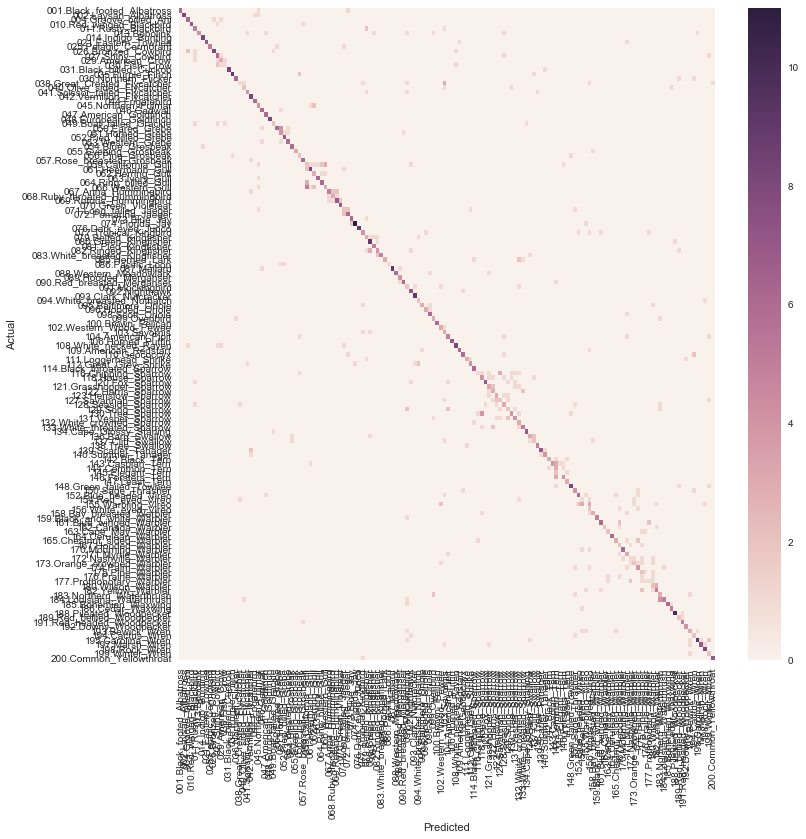

In [46]:
output_error_and_cm_for_classifier(ovo_pca, X_pca_test, y_pca_test)

With 128 components, I get a misclassification error of 34%. With 256 components, I get a misclassification error of 33%. This at least says it's cool to stay with 128 components. With 64 it takes 7s to train and I get a misclassification error of 39%. For now I'll optimize for compute and stay with 64.

_In a one-vs-rest fashion, for each class, train a linear SVM classiﬁer using scikit-learn’s function LinearSVC, with the default value for λc. Compute the multi-class misclassiﬁcation error obtained using these classiﬁers trained in a one-vs-rest fashion._

Initially since the default multiclass strategy for LinearSVC is one-vs-rest, I didn't plan to use the OneVsRestClassifier object. However, using OneVsRestClassifier is faster - as noted below - so I WILL use it after all.

Also, on whether to use the native features or PCA... training a OvR model still takes a while even though it's not as crazy time-consuming as OvO. I'll stay w/ the 256 PCA features - this is quicker, and it'll let me compare diff approaches apples-vs-apples. Even with the 256 features, it still takes the LinearSVC class 6m to train on the 256 components. It only takes 2:30 when I wrap it in the OneVsRestClassifier - what I see in CPU usage matches this, as the non-wrapped try only uses one CPU while the wrapped one uses both - so 

In [47]:
# # since we're not using the PCA features, get a new train-test split
# X_train, X_test, y_train, y_test = model_selection.train_test_split(X_scaled, labels_train, random_state=42)
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [48]:
#%time ovr_slow = LinearSVC(random_state=0, fit_intercept=False).fit(X_pca_train, y_pca_train)

In [49]:
#output_error_and_cm_for_classifier(ovr_slow, X_pca_test, y_pca_test)

In [50]:
%time ovr = OneVsRestClassifier(LinearSVC(random_state=0, fit_intercept=False), n_jobs=-1).fit(X_pca_train, y_pca_train)

CPU times: user 880 ms, sys: 109 ms, total: 989 ms
Wall time: 1min 8s


Misclassification error: 0.987037037037037.


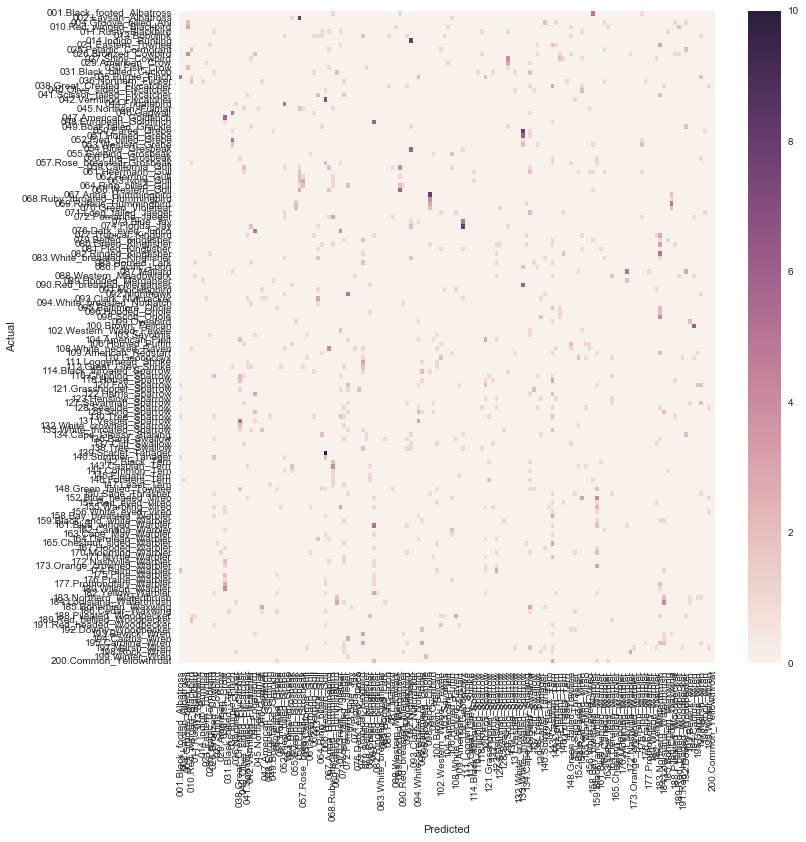

In [51]:
output_error_and_cm_for_classifier(ovr, X_pca_test, y_pca_test)

_Using the option multi class=’crammer singer’ in scikitlearn’s function LinearSVC, train a multi-class linear SVM classiﬁer using the default value for the regularization parameter. Compute the multi-class misclassiﬁcation error obtained using this multiclass linear SVM classiﬁer._

In [52]:
%time cs = LinearSVC(random_state=0, multi_class="crammer_singer", fit_intercept=False).fit(X_pca_train, y_pca_train)

CPU times: user 12.9 s, sys: 70.1 ms, total: 12.9 s
Wall time: 13.1 s


Misclassification error: 0.4388888888888889.


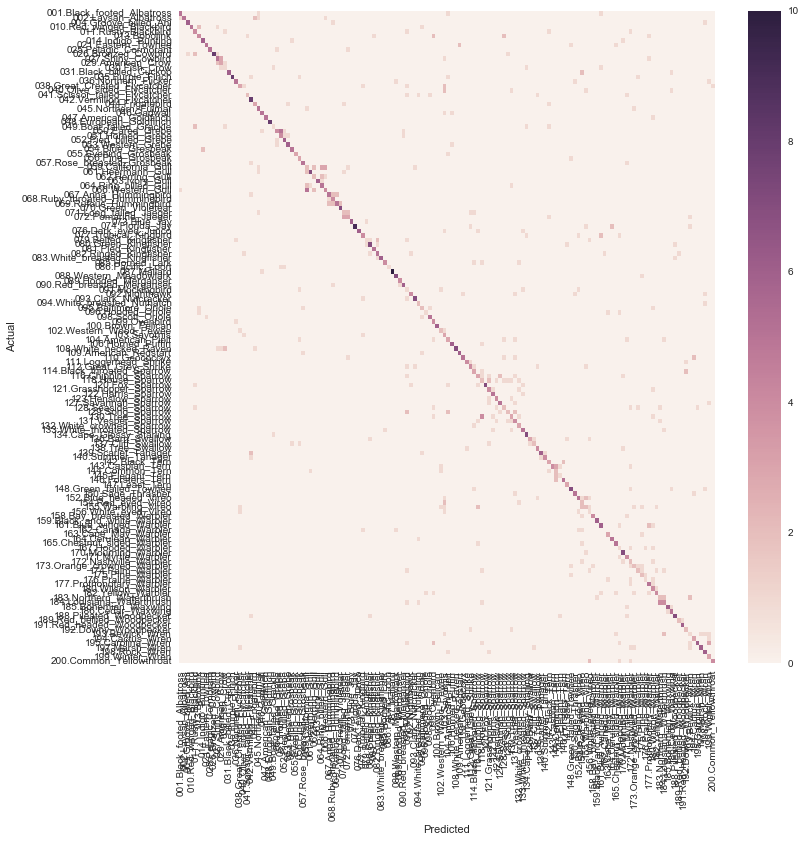

In [53]:
output_error_and_cm_for_classifier(cs, X_pca_test, y_pca_test)

## Linear SVMs for multi-class classiﬁcation

_Redo all questions above now tuning the regularization parameters using cross-validation._

_In a one-vs-one fashion, for each pairs of classes, train a linear SVM classiﬁer using scikit-learn’s function LinearSVC, with the default value for the regularization parameter. Compute the multi-class misclassiﬁcation error obtained using these classiﬁers trained in a one-vs-one fashion._

Note that I'm using sklearn's functionality here for setting params via cross-validation - this is ok because the assignment says specifically (emphasis added) "you are going to train support vector machines (SVMs) **using scikit-learn**" and never says that I need to use my own cross-validation code.

In [33]:
# param_grid = [
#   {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
# #   {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
#  ]

# tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
#                      'C': [1, 10, 100, 1000]},
#                     {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

param_grid = [
    {'estimator__C': [1, 10]}
]

In [36]:
# this one gives a 'Multiprocessing-backed parallel loops cannot be nested' warning and then I see that
# most of the time the CPU is not pegged. I'm not sure which of the parts of the eval - the CV inside 
# the classifier or the different params - is being set to n_jobs=1. perhaps I need to try with n_jobs=-1
# for both the inner and outer components and see what works best. 
# 
# Ok, so specifying n_jobs=-1 for both, and specifying it only for GridSearchCV both don't appear to work 
# well - they took many minutes when I knew I was only doing three models (I only had one param and three 
# CV folds). Fortunately, putting n_jobs=-1 only with the LinearSVC classifier took only 40s. The CPU usage
# pattern when doing this is interesting: it goes between using most of one core to using both cores 100%
# and back many times.

In [35]:
clf = GridSearchCV(OneVsOneClassifier(LinearSVC(fit_intercept=False), n_jobs=-1), 
                   param_grid, cv=3)
%time clf.fit(X_pca_train, y_pca_train)

CPU times: user 48.1 s, sys: 7.48 s, total: 55.6 s
Wall time: 1min 26s


GridSearchCV(cv=3, error_score='raise',
       estimator=OneVsOneClassifier(estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=False,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0),
          n_jobs=-1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'estimator__C': [1, 10]}], pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

In [37]:
clf.best_params_

{'estimator__C': 1}

In [38]:
clf.cv_results_

{'mean_fit_time': array([ 6.06438112,  5.53638347]),
 'mean_score_time': array([ 3.27298506,  2.77922829]),
 'mean_test_score': array([ 0.58117284,  0.58117284]),
 'mean_train_score': array([ 1.,  1.]),
 'param_estimator__C': masked_array(data = [1 10],
              mask = [False False],
        fill_value = ?),
 'params': ({'estimator__C': 1}, {'estimator__C': 10}),
 'rank_test_score': array([1, 1], dtype=int32),
 'split0_test_score': array([ 0.55447298,  0.55447298]),
 'split0_train_score': array([ 1.,  1.]),
 'split1_test_score': array([ 0.59666975,  0.59666975]),
 'split1_train_score': array([ 1.,  1.]),
 'split2_test_score': array([ 0.59417476,  0.59417476]),
 'split2_train_score': array([ 1.,  1.]),
 'std_fit_time': array([ 0.5248677 ,  0.30734926]),
 'std_score_time': array([ 0.20342881,  0.11041917]),
 'std_test_score': array([ 0.01955186,  0.01955186]),
 'std_train_score': array([ 0.,  0.])}

In [39]:
clf.cv_results_['params']

({'estimator__C': 1}, {'estimator__C': 10})

In [40]:
y_pred = clf.predict(X_pca_test)
y_pred[:3]

array(['036.Northern_Flicker', '010.Red_winged_Blackbird',
       '128.Seaside_Sparrow'], dtype=object)

In [41]:
print(classification_report(y_pca_test, y_pred))

                               precision    recall  f1-score   support

   001.Black_footed_Albatross       1.00      0.75      0.86         8
         002.Laysan_Albatross       1.00      0.80      0.89        10
        004.Groove_billed_Ani       0.67      0.75      0.71         8
     010.Red_winged_Blackbird       1.00      0.78      0.88         9
          011.Rusty_Blackbird       0.50      0.62      0.56         8
                 013.Bobolink       1.00      0.36      0.53        11
           014.Indigo_Bunting       0.89      1.00      0.94         8
           021.Eastern_Towhee       1.00      0.78      0.88         9
        025.Pelagic_Cormorant       1.00      0.71      0.83         7
          026.Bronzed_Cowbird       0.89      0.62      0.73        13
            027.Shiny_Cowbird       0.50      0.60      0.55        10
            029.American_Crow       0.50      0.67      0.57         6
                030.Fish_Crow       0.50      0.20      0.29         5
     

/Users/andrewenfield/miniconda3/envs/data558/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Misclassification error: 0.37870370370370365.


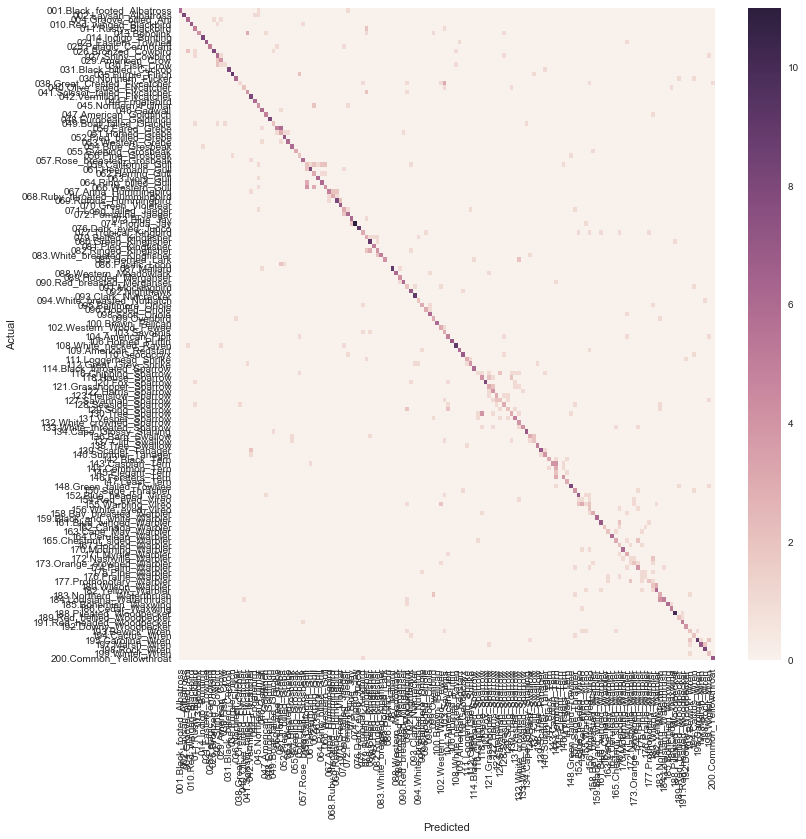

In [42]:
output_error_and_cm_for_classifier(clf, X_pca_test, y_pca_test)

_In a one-vs-rest fashion, for each class, train a linear SVM classiﬁer using scikit-learn’s function LinearSVC, with the default value for λc. Compute the multi-class misclassiﬁcation error obtained using these classiﬁers trained in a one-vs-rest fashion._

In [43]:
clfOvR = GridSearchCV(OneVsRestClassifier(LinearSVC(fit_intercept=False), n_jobs=-1), 
                   param_grid, cv=3)
%time clfOvR.fit(X_pca_train, y_pca_train)

CPU times: user 4.67 s, sys: 547 ms, total: 5.21 s
Wall time: 4min 29s


GridSearchCV(cv=3, error_score='raise',
       estimator=OneVsRestClassifier(estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=False,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0),
          n_jobs=-1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'estimator__C': [1, 10]}], pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

In [44]:
clf.best_params_

{'estimator__C': 1}

Misclassification error: 0.37870370370370365.


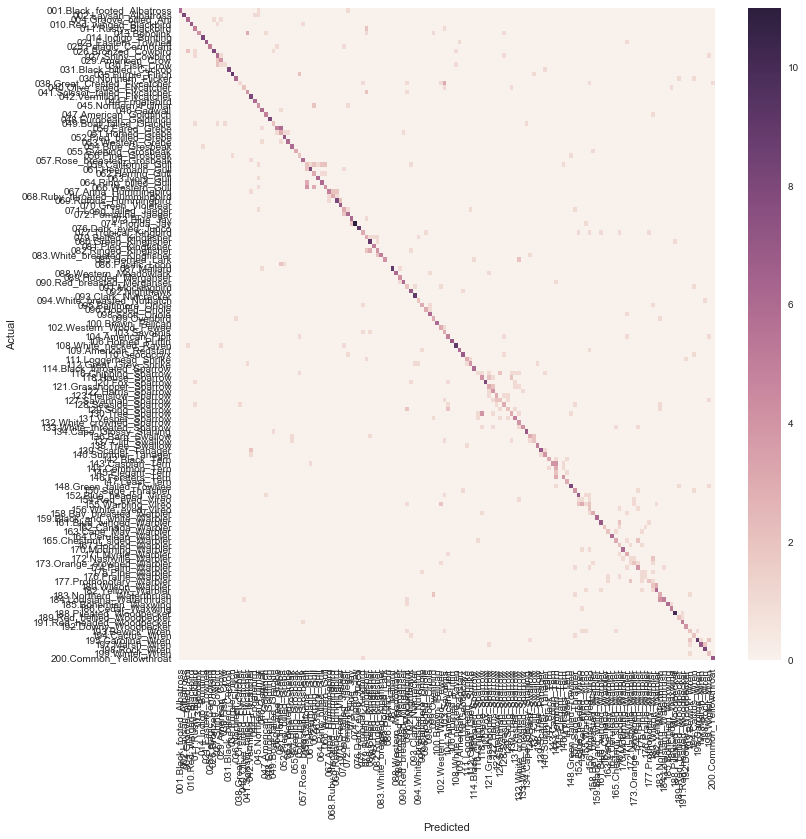

In [45]:
output_error_and_cm_for_classifier(clf, X_pca_test, y_pca_test)

_Using the option multi class=’crammer singer’ in scikitlearn’s function LinearSVC, train a multi-class linear SVM classiﬁer using the default value for the regularization parameter. Compute the multi-class misclassiﬁcation error obtained using this multiclass linear SVM classiﬁer._

This is a very time-consuming step. Not sure why, as running just one Crammer Singer takes only 10s or so. The first time I ran this it ran for 15m+ without stopping. Then I removed the n_jobs=-1 from the GridSearchCV and it finished in less than a minute.

In [46]:
# don't need the estimator__ to pass the param into a nested classifier, since we're not using OneVsRestClassifier
# or OneVsOneClassifier here.
cs_param_grid = [{'C': [1, 10]}]

In [49]:
clfCS = GridSearchCV(LinearSVC(multi_class="crammer_singer", fit_intercept=False), 
#                      cs_param_grid, n_jobs=-1, cv=3)
                      cs_param_grid, cv=3)
%time clfCS.fit(X_pca_train, y_pca_train)

CPU times: user 43.3 s, sys: 115 ms, total: 43.4 s
Wall time: 43.5 s


GridSearchCV(cv=3, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=False,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='crammer_singer', penalty='l2', random_state=None,
     tol=0.0001, verbose=0),
       fit_params={}, iid=True, n_jobs=1, param_grid=[{'C': [1, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [50]:
clfCS.best_params_

{'C': 1}

Misclassification error: 0.43981481481481477.


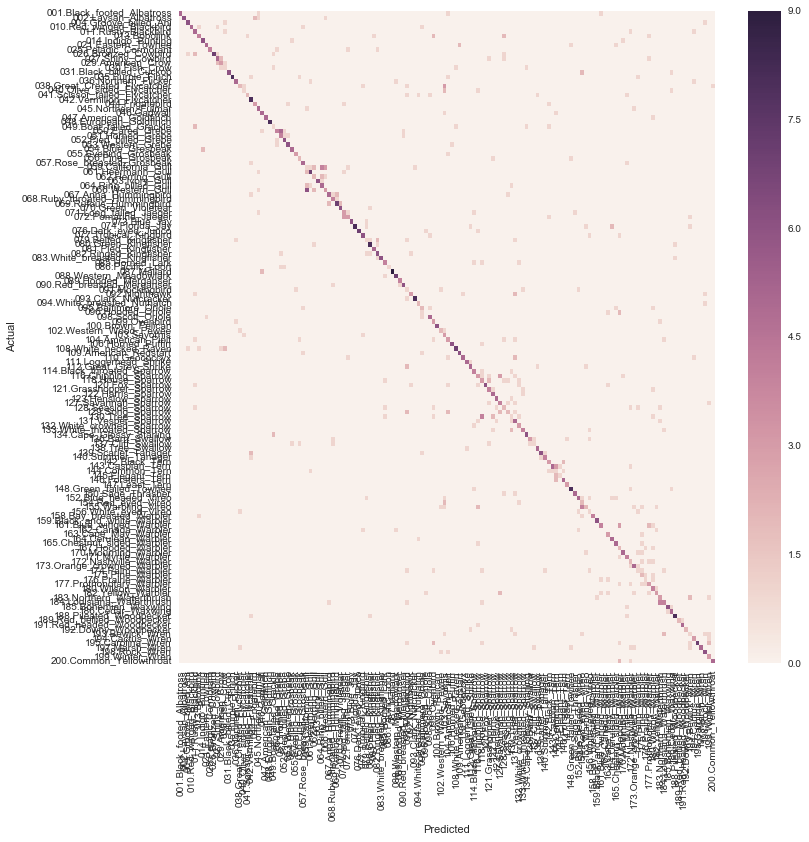

In [51]:
output_error_and_cm_for_classifier(clfCS, X_pca_test, y_pca_test)

## Kernel SVMs for multi-class classiﬁcation

_Redo all questions above now using the polynomial kernel of order 2 (and tuning the regularization parameters using cross-validation)._

Note that per the discussion board, since SVC doesn't do Crammer Singer we only do OvO and OvR for this step.

_In a one-vs-one fashion, for each pairs of classes, train a linear SVM classiﬁer using scikit-learn’s function LinearSVC, with the default value for the regularization parameter. Compute the multi-class misclassiﬁcation error obtained using these classiﬁers trained in a one-vs-one fashion._

When I ran this the first time the OvO fit took 13m, while the OvR fit took only 30s. Above removing the njobs=-1 improved the speed, but when I tried that here I saw no difference - it took 13m either way.

In [55]:
clfOvOPoly = GridSearchCV(OneVsOneClassifier(SVC(kernel='poly', degree=2), n_jobs=-1), param_grid, cv=3)
%time clfOvOPoly.fit(X_pca_train, y_pca_train)

CPU times: user 12min 21s, sys: 8.43 s, total: 12min 29s
Wall time: 13min 5s


GridSearchCV(cv=3, error_score='raise',
       estimator=OneVsOneClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=2, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=-1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'estimator__C': [1, 10]}], pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

In [56]:
clfOvOPoly.best_params_

{'estimator__C': 1}

Misclassification error: 0.3851851851851852.


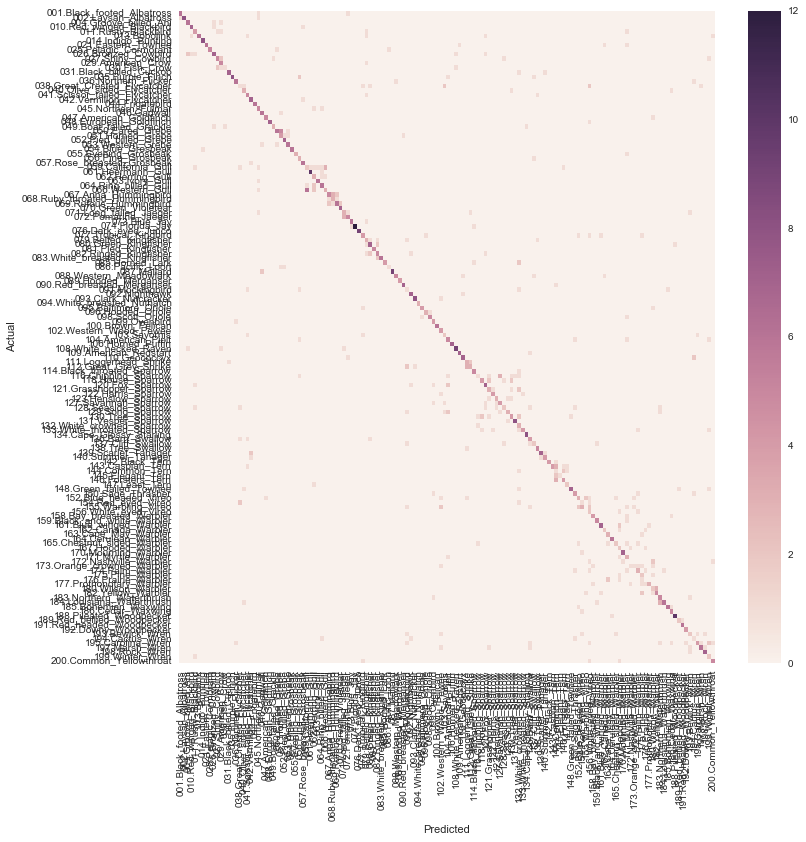

In [57]:
output_error_and_cm_for_classifier(clfOvOPoly, X_pca_test, y_pca_test)

_In a one-vs-rest fashion, for each class, train a linear SVM classiﬁer using scikit-learn’s function LinearSVC, with the default value for λc. Compute the multi-class misclassiﬁcation error obtained using these classiﬁers trained in a one-vs-rest fashion._

In [58]:
clfOvRPoly = GridSearchCV(OneVsRestClassifier(SVC(kernel='poly', degree=2), n_jobs=-1), param_grid, cv=3)
%time clfOvRPoly.fit(X_pca_train, y_pca_train)

CPU times: user 20.7 s, sys: 675 ms, total: 21.4 s
Wall time: 30.7 s


GridSearchCV(cv=3, error_score='raise',
       estimator=OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=2, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=-1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'estimator__C': [1, 10]}], pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

In [59]:
clfOvOPoly.best_params_

{'estimator__C': 1}

Misclassification error: 0.3851851851851852.


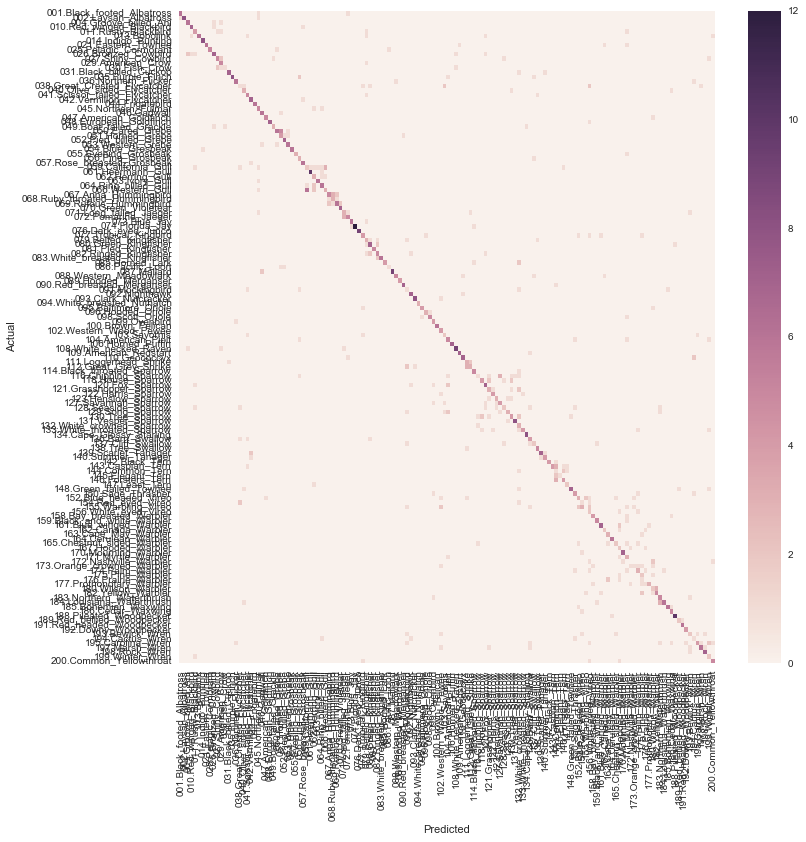

In [60]:
output_error_and_cm_for_classifier(clfOvOPoly, X_pca_test, y_pca_test)

_Using the option multi class=’crammer singer’ in scikitlearn’s function LinearSVC, train a multi-class linear SVM classiﬁer using the default value for the regularization parameter. Compute the multi-class misclassiﬁcation error obtained using this multiclass linear SVM classiﬁer._

We don't need to do this, per the discussion board and note above.

# Homework eight

_In this exercise, you are going to train kernel support vector machines (SVMs) using your own algorithms or scikit-learn on the data competition project dataset. You may work on this exercise on your own computer first. Note, however, that you need AWS to run the experiments._

_Compare the performance of SVMs for different types of kernels, tuning the kernel parameters using cross-validation. You may train the SVMs for multi-class classifica- tion in any fashion you wish (one-vs-one, one-vs-rest, multiclass). You may also use scikit-learn’s built-in functions to perform cross-validation over all parameters._

_Experiment with several ensembles of classifiers, using any technique you wish. You may consider bagging (ensembles of classifiers learnt from random subsamples of ex- amples), ensemble of classifiers learnt from random subsets of features, ensembles of classifiers with different kernels, etc._

# Experiment with actual test data

In [71]:
# features_test_pickled = np.array(pickle.load(open('features_test', 'rb')))
# labels_test_pickled = np.array(pickle.load(open('labels_test', 'rb')))
# features_test_pickled.shape, labels_test_pickled.shape

In [72]:
# pd.DataFrame(features_test_pickled).to_csv('features_test.csv', header=False, index=False)
# pd.DataFrame(labels_test_pickled).to_csv('labels_test.csv', header=False, index=False)

In [69]:
features_test = pd.read_csv('features_test.csv', header=None).values
labels_test = pd.read_csv('labels_test.csv', header=None).values.ravel()
features_test.shape, labels_test.shape

((4320, 2048), (4320,))

In [70]:
%time cs_all = LinearSVC(random_state=0, multi_class="crammer_singer", fit_intercept=False).fit(X_pca, labels_train)

CPU times: user 49.9 s, sys: 390 ms, total: 50.3 s
Wall time: 51 s


In [73]:
# sanity check - how well do we do on the data on which we trained
print("Accuracy: {0:0.1f}%".format(accuracy_score(labels_train, cs_all.predict(X_pca))*100))

Accuracy: 100.0%


In [77]:
# what about w/ the model that only saw the train set?
#print("Accuracy: {0:0.1f}%".format(accuracy_score(labels_train, cs.predict(X_pca))*100))

In [78]:
features_test_pca = pca.transform(features_test)
features_test_pca.shape

(4320, 64)

In [79]:
test_pred = cs_all.predict(features_test_pca)
test_pred.shape

(4320,)

In [80]:
test_results_for_output = pd.DataFrame({
    'Id': pd.Series(labels_test).astype(int), # use labels as they go 1, 10, 100, etc.
    'Prediction': pd.Series(test_pred).apply(lambda pred: pred.split('.')[0].lstrip('0'))
})
test_results_for_output.shape

(4320, 2)

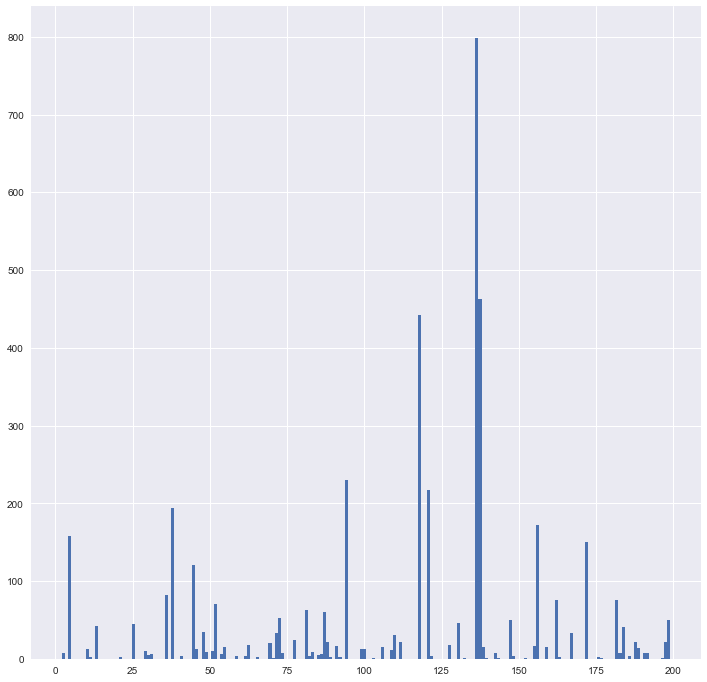

In [81]:
test_results_for_output['Prediction'].astype(int).hist(bins=200)

In [82]:
len(set(labels_train))

144

In [83]:
len(test_results_for_output['Prediction'].unique())

84

In [84]:
# Kaggle site code may not care about order, only id value, but sort by id just in case
test_results_for_output.sort_values('Id', inplace=True)  
test_results_for_output[:3]

,Id,Prediction
0,1,118
1111,2,38
2222,3,172


In [60]:
test_results_for_output.to_csv('test_crammer_singer.csv', index=False)

So, the above only gave me 27%, which isn't surprising given that the histogram is so spiky and we only predict 103 classes. Why do we get this, since the hold out set accuracy is so good? Perhaps I screwed up something w/ generating the test data? For one thing, did I do the PCA stuff correctly? Should I have fed all the features - all 9k - into PCA to start with, rather than just using transform w/ the new test data and the existing principal components?